<a href="https://colab.research.google.com/github/leewclee600/leewclee600.github.io/blob/master/efficientnets_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=7ab30958de043b9efe90ea21162f4adacbace59f9007b9b3ff033d2e1278fff4
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=ed341ebd610d36eef0a43bd9300627b4fb8a57f3d6b09080997c08975ed84738
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [ ]:
import os
import datetime
from functools import lru_cache
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from colorama import Fore, Back, Style

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)
ROOT = "../input/osic-pulmonary-fibrosis-progression/"

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [ ]:
train = pd.read_csv(os.path.join(ROOT, 'train.csv'))
test = pd.read_csv(os.path.join(ROOT, 'test.csv'))

# Linear Decay (based on EfficientNets)

In [ ]:
def get_agss_vector(df):
    
    """agss = age, gender, smokingstatus"""
    
    normalized_age = [(df.Age.values[0] - 30) / 30] 

    gender = [0 if df.Sex.values[0] == 'male' else 1]
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        smoking_status = [0, 0]
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        smoking_status = [1, 1]
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        smoking_status = [0, 1]
    else:
        smoking_status = [1, 0]

    vector = normalized_age + gender + smoking_status
    return np.array(vector)

In [ ]:
def sample_best_fit_line_weeks_vs_fvc():
    
    patient = train.Patient.sample().iloc[0]
    sub = train.loc[train.Patient == patient, :]
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    vals = np.c_[weeks, np.ones(len(weeks))]  # column-wise stack
    
    # see example https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    m, c = np.linalg.lstsq(vals, fvc, rcond=-1)[0]
    
    print(f"Patient number: {patient}")
    print("FVC", fvc)
    print("Weeks", weeks)
    print(vals)
    print(f"gradient: {m:.2f}\nintercept: {c:.2f}")
    print()
    _ = plt.plot(weeks, fvc, 'o', label='Original data', markersize=10)
    _ = plt.plot(weeks, m * weeks + c, 'r', label='Fitted line')
    _ = plt.legend()
    _ = plt.xlabel("Weeks"), plt.ylabel("FVC")
    plt.show()

Patient number: ID00099637202206203080121
FVC [2934 2866 3065 3089 3005 3001 2769 2708 2862 2833]
Weeks [ 44  47  49  51  53  58  70  83  98 102]
[[ 44.   1.]
 [ 47.   1.]
 [ 49.   1.]
 [ 51.   1.]
 [ 53.   1.]
 [ 58.   1.]
 [ 70.   1.]
 [ 83.   1.]
 [ 98.   1.]
 [102.   1.]]
gradient: -3.62
intercept: 3150.44



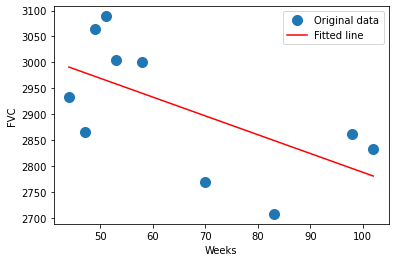

In [ ]:
# gradient = rate of decay in FVC values
sample_best_fit_line_weeks_vs_fvc()

In [ ]:
gradients = {} 
agss_vectors = {} 
patients = []

for i, patient_id in enumerate(train.Patient.unique()):
    sub = train.loc[train.Patient == patient_id, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.c_[weeks, np.ones(len(weeks))]
    gradient, intercept = np.linalg.lstsq(c, fvc, rcond=-1)[0]
    
    gradients[patient_id] = gradient
    agss_vectors[patient_id] = get_agss_vector(sub)
    patients.append(patient_id)

## CNN for coeff prediction

In [ ]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

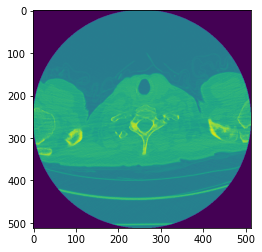

In [ ]:
# sample
_ = plt.imshow(get_img(os.path.join(ROOT, "train", "ID00007637202177411956430", "1.dcm")))

In [ ]:
from tensorflow.keras.layers import (
    Input,
    Activation,
    LeakyReLU,
    Dropout,
    BatchNormalization,
    Dense,
    Conv2D, 
    AveragePooling2D,
    GlobalAveragePooling2D,
    Add,
    Flatten,
    Concatenate,
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape, weights=None, include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape, weights=None, include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape, weights=None, include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape, weights=None, include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape, weights=None, include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape, weights=None, include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape, weights=None, include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape, weights=None, include_top=False),
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    
    img_inp = Input(shape=shape, name="image_input")
    base = get_efficientnet(model_class, shape)
    x = base(img_inp)
    img_outp = GlobalAveragePooling2D()(x)
    
    # AGSS = Age + Gender + SmokingStatus
    agss_inp = Input(shape=(4,), name="age_gender_smokingsstatus_input")
    agss_outp = tf.keras.layers.GaussianNoise(0.2)(agss_inp)
    
    x = Concatenate()([img_outp, agss_outp]) 
    x = Dropout(0.5)(x) 
    output = Dense(1)(x)
    
    model = Model([img_inp, agss_inp] , output)
    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w]
    assert len(weights) == 1, "More than one model weights match the 'model_class' substring"
    model.load_weights('../input/osic-model-weights/' + weights[0])
    
    return model

model_classes = ['b5']  # ['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [ ]:
models[0].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Model)         (None, 16, 16, 2048) 28512656    image_input[0][0]                
__________________________________________________________________________________________________
age_gender_smokingsstatus_input [(None, 4)]          0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           efficientnet-b5[1][0]            
______________________________________________________________________________________________

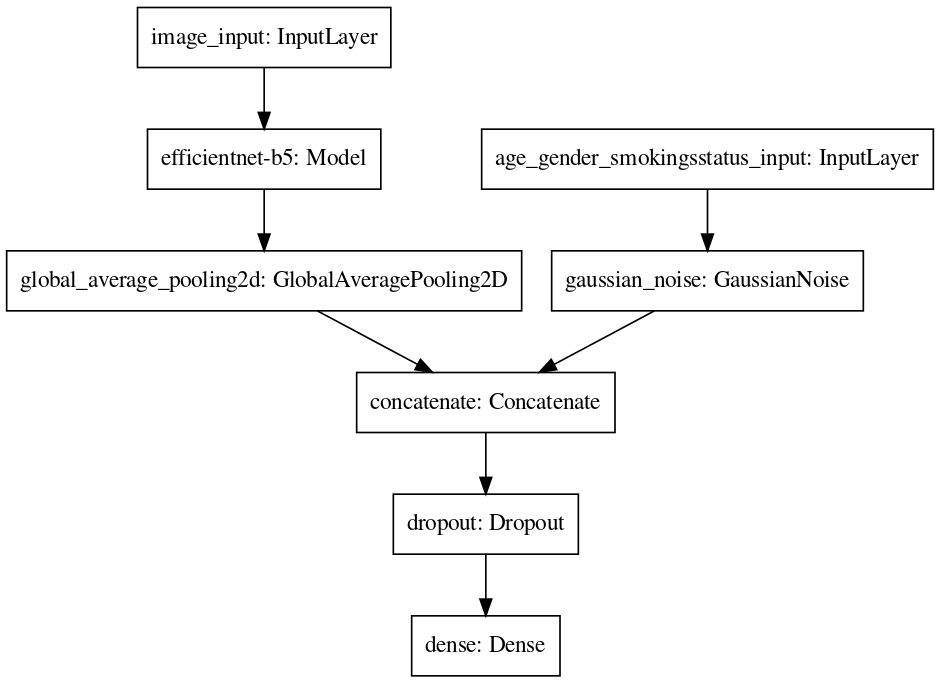

In [ ]:
tf.keras.utils.plot_model(
    models[0], 
    to_file='model.png',
    show_shapes=False, 
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False, 
    dpi=120,
)

In [ ]:
train_patients, validation_patients = train_test_split(patients, shuffle=True, train_size=0.8)

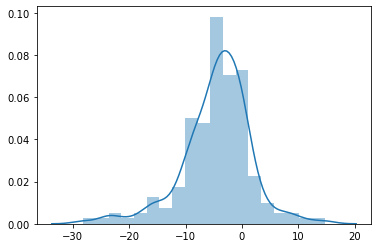

In [ ]:
sns.distplot(list(gradients.values()));

In [ ]:
DFs = {
    "train": train,
    "test": test,
}

In [ ]:
def fetch_images(patient_id, root=ROOT):
    image_files = os.listdir(os.path.join(root, f'train/{patient_id}/'))
    images = read_images_in_middle_of_scan(image_files, patient_id)
    return images

def read_images_in_middle_of_scan(image_files, patient_id, lower=0.15, upper=0.8):
    images = []
    for filename in image_files:
        file_no, _ = os.path.splitext(filename) # cut out '.dcm' file extension
        file_no = int(file_no)
        is_img_slice_in_middle = lower < file_no / len(image_files) < upper
        if is_img_slice_in_middle:
            image_filepath = os.path.join(ROOT, f'train/{patient_id}/{filename}')
            images.append(get_img(image_filepath))
    return images

def create_agss_vec_mat(patient_df, num_rows):
    agss_vector = get_agss_vector(patient_df)
    agss_matrix = np.array([agss_vector] * num_rows)
    return agss_vector, agss_matrix

def filter_df_with_patient_id(df, patient_id, patient_col="Patient"):
    return df.loc[df[patient_col] == patient_id, :]

def pred_fvc(x, m, c):
    """
    x --> weeks from base week
    m --> gradient i.e. rate of FVC decay (would be -ve for a patient with disease)
    c --> base week FVC
    """
    return m * x + c

def pred_confidence(base_percent, m, gap_in_weeks):
    """
    Predict confidence AKA "std deviation". Lower val means high confidence in predicted FVC.
    base_percent --> percentage in the base week
    m --> gradient i.e. rate of FVC decay (would be -ve for a patient with disease)
    gap_in_weeks --> just the gap irrespective of whether in the past or future
    """
    
    # the formula takes into account that as prediction moves away from the base week,
    # confidence drops (value gets bigger since m is or would be for most -ve)
    return base_percent - m * abs(gap_in_weeks)

def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip) * sq2 + np.log(sigma_clip * sq2)
    return np.mean(metric)

@lru_cache(1000)
def make_model_pred(df_name, patient_id, model_idx):
    global DFs
    df = DFs[df_name]
    patient_df = df[df.Patient == patient_id]
    images = fetch_images(patient_id)
    images = np.expand_dims(images, axis=-1)
    agss_vector, agss_matrix = create_agss_vec_mat(patient_df, num_rows=images.shape[0])
    return models[model_idx].predict([images, agss_matrix])

In [ ]:
def calc_patient_score(df_name, patient_id, quantile, model_idx, return_extra_vals=False):
    global DFs
    df = DFs[df_name]
    patient_df = df[df.Patient == patient_id]
    assert not patient_df.empty
    
    # model predicts for each image + agss_vector input
    gradients = make_model_pred(df_name, patient_id, model_idx)
    
    if gradients is None:
        return  # if no valid images in range, it will be None
    gradient = np.quantile(gradients, quantile)  # gradient @ quantile from gradients

    percent_true = patient_df.Percent.values
    fvc_true = patient_df.FVC.values
    weeks_true = patient_df.Weeks.values

    fvc_predict = pred_fvc(x=(weeks_true - weeks_true[0]), m=gradient, c=fvc_true[0])
    confidence = pred_confidence(base_percent=percent_true[0], 
                                 m=gradient, 
                                 gap_in_weeks=(weeks_true - weeks_true[0]),
                                )
    patient_score = score(fvc_true, fvc_predict, confidence)
    if not return_extra_vals:
        return patient_score
    else:
        return patient_score, gradient, fvc_predict, confidence

In [ ]:
subs = []
start = datetime.datetime.now()
for model_idx in range(len(models)):
    quantile_means = []
    quantiles = np.arange(0.1, 1.0, 0.05)
    for quantile in quantiles:
        
        print(f"Quantile: {quantile:.2f}", end=" -->  ")
        patient_scores_per_quantile = []
        
        for patient_id in validation_patients:
            if patient_id in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue
            one_patient_score_per_quantile = calc_patient_score("train", 
                                                                patient_id, 
                                                                quantile, model_idx,
                                                               )
            if one_patient_score_per_quantile is not None:
                patient_scores_per_quantile.append(one_patient_score_per_quantile)

        mean_quantile_score = np.mean(patient_scores_per_quantile)
        print(f"Patient scores mean for quantile {quantile:.2f}: {mean_quantile_score:.4f}")
        quantile_means.append(mean_quantile_score)

    sub = pd.read_csv(os.path.join(ROOT,'sample_submission.csv'))
    test = pd.read_csv(os.path.join(ROOT,'test.csv'))

    ## quantile with the smallest mean -> smallest error
    lowest_quantile_mean_idx = np.argmin(quantile_means)
    lowest_quantile = (lowest_quantile_mean_idx + 1) / 10

    gradient_test, calc_fvc_base_test, percent_test, base_weeks_test = {}, {}, {}, {}
    
    # this loop defines base parameters for each patient needed to calculate week-by-week prediction
    for patient_id in test.Patient.unique():
        _, gradient, *_ = calc_patient_score("test", 
                                             patient_id, 
                                             lowest_quantile,
                                             model_idx,
                                             return_extra_vals=True,
                                            )  # only gradient needed
        patient_df = test[test.Patient == patient_id]
        
        # test assumption: df will have 1 row since test set
        assert patient_df.shape[0] == 1
        
        gradient_test[patient_id] = gradient  # prediction value of the model
        
        # pred of FVC at week 0 itself. Other weeks will be predicted using this as base
        calc_fvc_base_test[patient_id] = (patient_df.FVC.values - 
                                          gradient * patient_df.Weeks).values[0]  

        percent_test[patient_id] = patient_df.Percent.values[0]
        base_weeks_test[patient_id] = patient_df.Weeks.values[0]

    # this loop predicts values (FVC and confidence) for each patient's each week
    for k in sub.Patient_Week.values:
        
        patient_id, week_no = k.split('_')
        week_no = int(week_no)
        
        gradient = gradient_test[patient_id]
        base_fvc = calc_fvc_base_test[patient_id]
        base_percent = percent_test[patient_id]
        base_week = base_weeks_test[patient_id]
        gap_from_base_week = base_week - week_no
        
        predicted_fvc = pred_fvc(week_no, m=gradient, c=base_fvc)
        predicted_conf = pred_confidence(base_percent,
                                         m=gradient,
                                         gap_in_weeks=gap_from_base_week,
                                        )
        
        sub.loc[sub.Patient_Week==k, 'FVC'] = predicted_fvc
        sub.loc[sub.Patient_Week==k, 'Confidence'] = predicted_conf
    
    sub_ = sub[["Patient_Week", "FVC", "Confidence"]].copy()
    subs.append(sub_)
end = datetime.datetime.now()
print(end - start)

Quantile: 0.10 -->  Patient scores mean for quantile 0.10: 6.5767
Quantile: 0.15 -->  Patient scores mean for quantile 0.15: 6.5767
Quantile: 0.20 -->  Patient scores mean for quantile 0.20: 6.5767
Quantile: 0.25 -->  Patient scores mean for quantile 0.25: 6.5767
Quantile: 0.30 -->  Patient scores mean for quantile 0.30: 6.5767
Quantile: 0.35 -->  Patient scores mean for quantile 0.35: 6.5767
Quantile: 0.40 -->  Patient scores mean for quantile 0.40: 6.5767
Quantile: 0.45 -->  Patient scores mean for quantile 0.45: 6.5767
Quantile: 0.50 -->  Patient scores mean for quantile 0.50: 6.5767
Quantile: 0.55 -->  Patient scores mean for quantile 0.55: 6.5767
Quantile: 0.60 -->  Patient scores mean for quantile 0.60: 6.5767
Quantile: 0.65 -->  Patient scores mean for quantile 0.65: 6.5767
Quantile: 0.70 -->  Patient scores mean for quantile 0.70: 6.5767
Quantile: 0.75 -->  Patient scores mean for quantile 0.75: 6.5767
Quantile: 0.80 -->  Patient scores mean for quantile 0.80: 6.5767
Quantile: 

## Averaging Predictions

In [ ]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [ ]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3092.865257,143.052113
1,ID00421637202311550012437_-12,2847.514586,190.559877
2,ID00422637202311677017371_-12,2002.671623,149.344117
3,ID00423637202312137826377_-12,3410.771229,196.030132
4,ID00426637202313170790466_-12,2971.473869,118.298837
